#Introduction
The aim of the project is to create a videogame recommender system based on the recommendations provided by users on the Steam platform.

The reasons behind the choice to use Steam are several:


*   Steam is at the moment the biggest videogame store online that also provides a "community mechanic" for their users. The users (that arrives to be 120 million active users each month) have the possibility to create their profile not only to store the games buyed but also to share with their friends the "achievments" that they can get in game and more importantly they have the possiblity to leave reviews on each game on the catalogue in order to communicate their preferences to other users
*   Steam is a highly friendly platform for developer, meaning that they provide APIs to fetch data from their website and also are not against scraping (as long as it compell the robots.txt - http://steamcommunity.com/robots.txt - of the website and is not used in order to create bots to automate transactions, spamming and so on...) meaning that is possible to collect up-to-date data without having too many restrictions
*   If a game is distributed on PCs it will very probable that it will distributed also on Steam; beside some notable exclusive for other online store platform (i.e. Fortnite, Genshin Impact, Minecraft, ...), Steam can be saw as the most comprehensive online store (since it is not tieded to any specific publisher) in which the most of the games for PC can be found


In the following sections I will illustrate the job done in order to create the recommender system. Specifically the following topics will be covered


1.   Dataset Collection
2.   Data Cleaning
3.   Recommendations' Translation
4.   Data Analysis
5.   AGGIUNGI LE ALTRE




#Dataset Collection
In the following section I will explain how I was able to get the dataset needed for the system from the Steam Store.

In order to get the data (as I will explain in a detailed way later) I used the APIs provided by the Store and an ad-hoc web scraper.

## Needed library import

In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Connection to Google Drive

In [2]:
# Connect this colab to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Check dataset files presence

In [3]:
# Checks if the folder in which the dataset is contained is present on Google
# Drive, if it is not present it will proceed with the execution of the scripts
# that I used to collect the data

# Each flag will check if a specific part of the dataset is present in the
# folder and if not present it will compute that specific part of the dataset
# collection

# This flag is used to check if the file in which the informations about each
# game (either tagged as 'game' or 'DLC') on the store is present
games = os.path.exists("/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv")
# This flag is used to check if the file in which the informations about the
# users (called 'players' from now on) is present
players = os.path.exists("/content/gdrive/MyDrive/VideogameRecommenderSystem/players.csv")
# This flag is used to check if the file in which the informations about the
# recommendations (also called 'reviews' from now on) leaved by the players is
# present
game_reviews = os.path.exists("/content/gdrive/MyDrive/VideogameRecommenderSystem/game_reviews.csv")
# This flag is used to check if the file in which the informations about the
# statistics on the average time used to complete a game is present
hours_stat = os.path.exists("/content/gdrive/MyDrive/VideogameRecommenderSystem/hours_stat.csv")

### Missing *games.csv* file
If the file containing the informations about the games (either complete games or DLCs) is missing, the following script will be executed.

The script acts as following:


*   Import all the needed libraries
*   Defines the function that is needed to process the response get from the request to the site for the specific game information
* Download the most up-to-date file containing **all** the applications that are present on the store; it is important to notice that not all the application on the store are games (or DLCs), in fact Steam also has listed additional contents for games like soundtracks or artbooks, naturally these items are not interesting for the recommender system so they must be discarded, however the only way to do that is to check for specific informations about the application, see the category of the item and filter them by only maintaining the ones whose category is either *game* or *DLC*
* Saves the information about the interesting items; specifically the script will save the **commercial name** of the application (corresponding to the *name* column in the file), the **appid** of the application which is the **unique identificator** of the application on the store (corresponding to the *steam_appid* column in the file), the **type** of the application (either *game* or *DLC* and corresponding to the *type* column in the file), the **description of the game** provided by the developer/publisher (corresponding to the *about_the_game* column in the file), the **synopsis of the game** (corresponding to the *short_description* column of the file) and the **number of recommendations** that are present on the store for the specific application (corresponding to the *total_recommendation* column in the file). As for the recommendations is important to notice that the value could not be the same as the one that actually is on the store (meaning that there could be some games that have on the file **less** reviews than the one that are actually on the store): this is due to a limitation of the API that only get the reviews that has been written in the past 365 days from the day in which the request is made (so as it will be described later, in order to get the most of the reviews the API has not been used in favor of an ad-hoc scraper that actually is able to get more reviews)
* AGGIUNGI DESCRIZIONE DELLA PULIZIA FATTA



In [4]:
# Import needed libraries for the script
if not games:
  import requests
  import json
  import pandas as pd
  from tqdm import tqdm
  import csv
  import time
  import os
  import re


  def get_game_info(app_id):
    """
    This function takes the app_id of a game and returns the information
    about the game from the Steam API.
    """
    url = f'http://store.steampowered.com/api/appdetails?appids={app_id}'
    try:
      response = requests.get(url)
    except:
      with open('output_files/error_log.csv', 'a') as F_err:
        writer = csv.writer(F_err)
        writer.writerow([app_id])
      return {}
    data = response.json()
    # The data could be None if the time-limit amount of requests
    # given by the API is exceeded
    if data == None:
      with open('output_files/error_log.csv', 'a') as F_err:
        writer = csv.writer(F_err)
        writer.writerow([app_id])
      return {}
    # The success of the request can be True if the application is public
    # and has information to be read or False if the application cannot be
    # saw by users and so it does not have public information to be read
    if data[str(app_id)]['success']:
      return data[str(app_id)]['data']
    else:
      return {}


  # This framework is useful in case of the freeze of the script due to possible
  # errors: since new applications are added to the store very frequently, it is
  # useful to define the set of the applications to be checked to a specific
  # AppList downloaded at the beginning of the dataset collection

  # Check for the existence of the Steam application file
  # If not present, download it
  # CONTROLLA POI STA COSA DI OUTPUT_FILES
  if not os.path.exists('output_files/apps.csv'):
    print('Steam application file not found. Downloading it...')
    URL = 'https://api.steampowered.com/ISteamApps/GetAppList/v2/'
    # In this case the try-except is not needed because this file is always
    # downloadable
    r = requests.get(url=URL)
    apps_data = r.json()
    # CONTROLLA QUALI SONO GLI ALTRI CAMPI DEL FILE JSON
    apps_data = apps_data['applist']['apps']
    with open('output_files/apps.json', 'w') as F:
        json.dump(apps_data, F)
    # The file is then converted to json and then to csv in order to have a
    # more friendly usable file
    df = pd.read_json('output_files/apps.json')
    df.to_csv('output_files/apps.csv', index=None)
  else:
    print('Steam application file found. Loading it...')


  # Read the Steam application file as dataframe
  # and get only the identifier of the applications
  df = pd.read_csv('output_files/apps.csv')
  app_ids = df['appid']

  # Checks if the file containing the needed information about the partial dataset
  # is present; if not create it
  if not os.path.exists('output_files/games.csv'):
    with open('output_files/games.csv', 'w') as F:
      writer = csv.writer(F)
      cols = ['name', 'steam_appid', 'type', 'about_the_game', 'short_description', 'total_recommendations', ]
      writer.writerow(cols)

  # Same as before, but the 'other.csv' file will contain all the applications that
  # are not games or DLCs
  if not os.path.exists('output_files/other.csv'):
    with open('output_files/other.csv', 'w') as F_1:
      writer_1 = csv.writer(F_1)
      cols = ['steam_appid']
      writer_1.writerow(cols)

  # Loop over the entire list of application to find games and DLCs
  for i, row in tqdm(app_ids.to_frame().iterrows(), total = app_ids.shape[0]):
    # This sleep is needed to avoid the overcame of the time-limit of the API
      if i%20 == 0:
          time.sleep(15)
      app_id = row['appid']
      game_info = get_game_info(app_id)
      if game_info != {}:
          if game_info['type'] == 'game' or game_info['type'] == 'dlc':
              data = []
              data.append(game_info['name'])
              data.append(game_info['steam_appid'])
              data.append(game_info['type'])
              data.append(game_info['about_the_game'])
              data.append(game_info['short_description'])
              try:
                  data.append(game_info['recommendations']['total'])
              except KeyError:
                  data.append(0)
              with open('output_files/games.csv', 'a') as F:
                writer = csv.writer(F)
                writer.writerow(data)
          else:
            with open('output_files/other.csv', 'a') as F_1:
              writer_1 = csv.writer(F_1)
              writer_1.writerow([app_id])
      else:
        with open('output_files/other.csv', 'a') as F_1:
          writer_1 = csv.writer(F_1)
          writer_1.writerow([app_id])

  # Needed clean in order to correctly format the csv file
  CLEANER_TAGS = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  CLEANER_SEPARATORS = re.compile(r'[,\t;|]')

  def clean_html(raw_html):
    cleantext = re.sub(CLEANER_TAGS, '', raw_html)
    return cleantext

  def clean_separators(raw_text):
    cleanedtext = re.sub(CLEANER_SEPARATORS, '', raw_text)
    return cleanedtext

  def format_string(raw_text):
    return ' '.join(raw_text.split())

  games_df = pd.read_csv("/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv")

  games_df['name'] = games_df['name'].astype(str)
  games_df['name'] = games_df['name'].apply(clean_separators)
  games_df['name'] = games_df['name'].apply(format_string)

  games_df['about_the_game'] = games_df['about_the_game'].astype(str)
  games_df['about_the_game'] = games_df['about_the_game'].apply(clean_html)
  games_df['about_the_game'] = games_df['about_the_game'].apply(clean_separators)
  games_df['about_the_game'] = games_df['about_the_game'].apply(format_string)

  games_df['short_description'] = games_df['short_description'].astype(str)
  games_df['short_description'] = games_df['short_description'].apply(clean_html)
  games_df['short_description'] = games_df['short_description'].apply(clean_separators)
  games_df['short_description'] = games_df['short_description'].apply(format_string)

  games_df = games_df[['name', 'steam_appid', 'type', 'about_the_game', 'short_description', 'total_recommendations']]

  games_df.to_csv('/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv', index=False)

else:
  print("'games.csv' file found")

'games.csv' file found


### Missing *players.csv* file
If the file containing the informations about the games (either complete games or DLCs) is missing, the following script will be executed.

The script acts as following:


*   At first imports all the needed libraries
*   Then filters the games collected before by getting only the ones for which the *total_recommendation* column in the file *games.csv* has at least 1 recommendation (as said before this could not get all the games that have at least one recommendation due to the year-limit of the API but this limit will overcome later during the collection of the reviews that will be done starting from the players and not from the games)
* Then for each one of the games filtered the script will try to get the **first 100 players** by retrieving the **100 most valuable reviews** for the game. The Steam store in fact gives the possibility to the user to judge the reviews left by other players by voting them as *useful* or *not useful*. By providing the request made in the script the API will return as result at most the first 100 reviews that were also judged as the most useful for the game. This decision has been made in order to avoid troll reviews or reviews done for review bombing which are pretty common in Steam
* The Steam identification numbers of the players are then saved in the *players.csv* file



In [5]:
if not players:
  # Import the needed libraries
  import requests
  import csv
  import pandas as pd
  from tqdm import tqdm
  import time
  import os


  # Filter to get only the games that in the last year have been reviewed at
  # least one time
  df = pd.read_csv('output_files/games.csv')
  df_tmp = df[df['total_recommendations']>0]
  app_ids = df_tmp['steam_appid'].tolist()


  # Prepare to save the players, it is important to use a set because it is
  # important to not have duplicated users from which the reviews will be
  # later retrieved
  players = set()


  # This framework is used to make the script robust to errors and to possible
  # re-execution.
  # The script first checks if some players were already found, if not it will
  # create the file to save their ids
  if not os.path.exists('output_files/players.csv'):
    print("No players found.")
    with open('output_files/players.csv', 'w') as F:
      writer = csv.writer(F)
      cols = ['steam_id', ]
      writer.writerow(cols)
  # If some players were already saved then the starting set is set to the
  # ids that were previously collected
  else:
    print("Some players found, ids loaded.")
    df_players = pd.read_csv('output_files/players.csv')
    players = set(df_players['steam_id'].tolist())

  # This file is used to collect possible games whose resolution is not
  # successful and it is mostly used to have an hint of the 'health' of the
  # current execution of the script and so is created at any execution of the
  # script
  with open('output_files/error_appid.csv', 'w') as F_1:
    writer_1 = csv.writer(F_1)
    cols = ['steam_appid', ]
    writer_1.writerow(cols)

  # This file collects the games for which the 100 most valuable players have
  # been collected, since the script must be resilient to error and re-executions
  # at any new execution the script will check for its existence and if the file
  # is not found it will create it
  if not os.path.exists('output_files/resolved_appid.csv'):
    print('No resolved ids found.')
    with open('output_files/resolved_appid.csv', 'w') as F_2:
      writer_2 = csv.writer(F_2)
      cols = ['steam_appid', ]
      writer_2.writerow(cols)
  # Naturally if the file is found it means that some games were already resolved
  # and in order to not make duplicate requests the appids of the resolved
  # applications are removed from the list of the applications that must be
  # resolved in the execution
  else:
    print('Already resolved some games ids, removing them from the list...')
    df_resolved = pd.read_csv('output_files/resolved_appid.csv')
    resolved_app_ids = df_resolved['steam_appid'].tolist()
    app_ids = list(set(app_ids) - set(resolved_app_ids))


  # Loops over all the appids that must be resolved
  for app_id in tqdm(app_ids, total=len(app_ids)):
    # Try to get the 100 most valuable reviews (and following the 100 most
    # valuable users that have written those reviews)
    url = f'https://store.steampowered.com/appreviews/{app_id}?json=1&language=all&num_per_page=100'
    # This sleep is needed in order to not exceed the time-limit imposed by the
    # API
    time.sleep(1)
    try:
      response = requests.get(url)
    except:
      with open('output_files/error_appid.csv', 'a') as F_1:
        writer_1 = csv.writer(F)
        writer.writerow([app_id])
        continue
    if response.status_code == 200:
      data = response.json()
      # If the request is successfull for each review got save the player id
      with open('output_files/players.csv', 'a') as F:
        writer = csv.writer(F)
        for review in data['reviews']:
          player_id = review['author']['steamid']
          if player_id not in players:
            players.add(player_id)
            writer.writerow([player_id])
      # And save the appid as one that has been resolved
      with open('output_files/resolved_appid.csv', 'a') as F_2:
        writer_2 = csv.writer(F_2)
        writer_2.writerow([app_id])
    else:
      with open('output_files/error_appid.csv', 'a') as F_1:
        writer_1 = csv.writer(F_1)
        writer_1.writerow([app_id])
else:
  print("'players.csv' file found")

'players.csv' file found


### Missing *games_reviews.csv* file
After getting all the players interesting for the system it's time to collect the reviews that they wrote.
The aim of the project is to create a **collaborative filtering recommender system** and for this reason is important to collect the reviews not much for the specific items that the system will recommend but moreover for the specific users of the system that will later on be used in order to compute the similarities among the user that wants the recommendation and the ones that are collected in the system.
The Steam APIs (in addition of not having the possibility to check for reviews older than 1 year from the request - which can be naturally a big problem since, excluding some games that are continuously consumed by new users, games are usally reviewed only in the few following months from the publishing) does not actually give the possibility to get the reviews starting from the users.
In order to overcome this two big limitation an ad-hoc scraper has been created.

The script used to retrieve the games review starting from the users acts as following:


*   Import all the needed libraries
*   Define the function that is used, given a Steam id for an user and a page number indicating a page of their *review section* on their Steam profile, will parse the HTML page got as response of the request and save **only** the reviews from the response
*   Retrieve the previously found players
*   For each one of the found players, the script will get all the reviews written by the players together with the needed information got from the reivew


It is important to notice that the saved information for each review are: **Steam id of the author** (corresponding to the *steam_id* column in the file), the **Application id for which the review has been written** (corresponding to the *app_id* column in the file), the **recommendation** given by the user for the application (can either be *Recommended* or *Not Recommended* and it's corresponding to the *recommended* column in the file) and the **amount of hours for which the user has played the game** (can be not present or present with two different values corresponding to the **total amount of time for which the user has been playing the game** and the **total amount of time for which the user has played the game at the moment of the writing of the review**; this data corresponds to the *hours_played* in the file).
There are two important aspects that deserve to be mentioned: the first one is that it has been decided to not take in consideration the textual feedback given by the users; this is because the textual feedback is not actually mandatory in order to submit a review for a game and also because even if present the textual feedback can be actually unusefull in order to understand the feeling of the user towards the game (since it can be composed by emoticons or ASCII drawings). The second one is strictly connected to the aspect just mentioned: as already said the recommendations on Steam can only be categorized as *Recommended* or *Not Recommended* meaning the user cannot express **how much** they recommend or not a game; it's in this situation that the **hours that players spent playing the games** are helpful: by having an idea of **how much is the average time to complete a game** (which will be later explained) it is possible to convert the simple recommendation on a larger scale of grades (by taking in account how much time they spent before writing the review, if they continued playing the game after that and so on...). Naturally not all the reviews are connected to the play-time of the users (since it's possible to pla the games without having Steam collecting the user data about the gaming experience), in this case the reviews will be considered *neutral with a positive (or negative) meaning*.




In [6]:
if not game_reviews:
  # Import the needed libraries
  import requests
  # DA CONTROLLARE SE BEAUTIFUL SOUP VA INSTALLATA CON PIP QUA SU COLAB
  from bs4 import BeautifulSoup
  import csv
  import pandas as pd
  from tqdm import tqdm
  import time
  import os


  # Define the function needed to retrieve all the reviews written by an user
  # and found in a specific page of the review section of their profile
  def get_reviews(steam_id, page_number):
    """
    This function parse the given page page_number for the review section of the
    of the user profile with steam_id identification number. From the page it
    returns the list of all the reviews in page (all characterized by the tag
    <class='review_box'> in the HTML page)
    """
    url = f"https://steamcommunity.com/profiles/{steam_id}/recommended/?p={page_number}"
    # The user agent is defined in order to avoid to be recognized as a Python
    # bot by the website
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    reviews = soup.findAll('div', {'class': 'review_box'})
    return reviews


  # Get all the previously found players
  df_players = pd.read_csv('output_files/players.csv')
  steam_ids = set(df_players['steam_id'].tolist())


  # This framework is used in order to make the script resilient to errors and
  # re-execution
  # Specifically at any execution it will check if the file containing the reviews
  # is present; if not it will create it
  if not os.path.exists('output_files/game_reviews.csv'):
    print("Creating review file...")
    with open('output_files/game_reviews.csv', 'w') as F:
      writer = csv.writer(F)
      cols = ['steam_id', 'app_id', 'recommended', 'hours_played']
      writer.writerow(cols)
  # If it is present the reviews will be appended to the pratial result
  else:
    print("Review file found, next reviews will be appended")

  # As before the error file is used to have an hint of the 'health' of the
  # execution and to store all the users ids for which the retrieving of the
  # reviews has not worked.
  # Since the error file is not used to successfully resume execution after an
  # interruption the file is created brand new at any execution
  with open('output_files/error_steam_ids.csv', 'w') as F_1:
    writer_1 = csv.writer(F_1)
    cols = ['steam_id']
    writer_1.writerow(cols)

  # As before it is important to save the resolved user for which the reviews
  # has already been collected, so it is important to have a file that stores
  # all the resolved users, the script will check at any execution if the file is
  # present: if not it will create it
  if not os.path.exists('output_files/resolved_steam_ids.csv'):
    print("No resolved steam ids found.")
    with open('output_files/resolved_steam_ids.csv', 'w') as F_2:
      writer = csv.writer(F_2)
      cols = ['steam_id']
      writer.writerow(cols)
  # If not present the alreay resolved users will be deleted from the ones that
  # must be resolved.
  # It is important to notice that this framework limits the duplication in case
  # of abruption of the script: in fact the worst case is the one for which the
  # script interrupts while having resolved some but not all the reviews for a user.
  # In this case at the following execution of the script that user will be again
  # resolved and some of the reviews will be duplicated but they can be easily
  # removed later
  else:
    print("Some resolved steam ids found, ids loaded.")
    df_resolved = pd.read_csv('output_files/resolved_steam_ids.csv')
    resolved_steam_ids = df_resolved['steam_id'].tolist()
    steam_ids = list(set(steam_ids) - set(resolved_steam_ids))


  # Loops for each user that must be resolved
  for steam_id in tqdm(steam_ids, total=len(steam_ids)):
    # i is a counter that show at which page of the 'reviews' section of the
    # profile of a specific user the script has arrived; it is important to
    # notice that the pages will always start from 1 and goes on up until all
    # the reviews has been showed
    # When analyzing a new user the page counter is set to 0
    i = 0
    # This sleep is used to wait a bit before processing a new user, in this
    # way the Steam website will never be overflooded by requests and the
    # scraping won't go against the terms of usage
    time.sleep(1.5)
    # Up until is possible to find more reviews
    while True:
      # The script will analyze a new page of the 'review' section of the profile
      i += 1
      try:
        reviews = get_reviews(steam_id, i)
      except:
        with open('output_files/error_steam_ids.csv', 'a') as F_1:
          writer_1 = csv.writer(F_1)
          writer_1.writerow([steam_id])
          break
      # If some reviews are found
      # This check is useful because for each user is possible to check any page
      # wanted to be checked from the 'review' section of the profile but if the
      # user did not wrote as much reviews needed to complete all the previous
      # pages the list returned by the parser will be empty
      if reviews != []:
          # For each review written by the user collect all the needed informations
          for review in reviews:
            review_data = []
            # The author of the review
            review_data.append(str(steam_id))
            # The steam application id: in the section of the HTML page
            # characterized by the tag <class='game_capsule_ctn'> is present a
            # picture representing the thumbnail of the game, the image is linked
            # to the application page on the Steam store and so it is possible
            # to get from the link the Steam appid of the application.
            # All the links have the following structure
              # https://steamcommunity.com/app/{app_id}
            # and so the app_id can be found starting from the character present
            # in the position 3 of the string up until the end of the link
            app_id = review.find('a', {'class': 'game_capsule_ctn'})['href'][31:]
            review_data.append(app_id)
            # The value for the recommendation of the review
            recommended = review.find('div', {'class': 'title'}).text
            review_data.append(recommended)
            # The amount of hours played by the user for the game
            hours_played = review.find('div', {'class': 'hours'}).text
            hours_played = hours_played.replace('\r', '')
            hours_played = hours_played.replace('\n', '')
            hours_played = hours_played.replace('\t', '')
            review_data.append(hours_played)
            # Then save the information for the review
            with open('output_files/game_reviews.csv', 'a') as F:
              writer = csv.writer(F)
              writer.writerow(review_data)
      # When no more new pages with reviews can be found than the user can be
      # considered resolved
      else:
        with open('output_files/resolved_steam_ids.csv', 'a') as F_2:
          writer_2 = csv.writer(F_2)
          writer_2.writerow([steam_id])
          break


  # After getting all the reviews is important to maintain only the ones about
  # the apps that are in the 'games.csv' since it could happen that there are
  # some reviews about games that are not in the total lists of game that the
  # recommender system is considering
  df_rev = pd.read_csv('output_files/game_reviews.csv')
  df_game = pd.read_csv('output_files/games.csv')

  df_game = df_game[['name', 'steam_appid']]
  df_rev = df_rev[df_rev['app_id'].isin(df_game['steam_appid'])]
  df_rev.to_csv('output_files/game_reviews.csv', index=False)
else:
  print("'game_reviews.csv' file found")

'game_reviews.csv' file found


### Missing *hours_stat.csv* file
As already mentioned in order to get the *graded value* of a review written by an user is important to know the average time needed to complete a game (in this way it's possible to compare how many hours the played the game and understand if the user had a complete knowledge about the game in order to express the recommendation). Since knowing how long a game is it has always been an important notion for gamers, there is a portal, called *howlongtobeat* that provide the amount of time (estimated from the data given by the user of the platform) that is needed to complete a game.
How Long To Beat actually provides at most 4 different possible values: the amount of time needed to **complete the main storyline**, the amount of time needed to **complete the main storyline and the extra-quests**, the amount of time needed to **complete the game at 100%** (with all the secrets) and an **average among them**.
It is importat to understand though that not all the games present on Steam are also listed on HLTB (since Steam is full of indie simulators that are not widely played)

In order to retrieve the data from the website the API has been used. The script used to retrive the needed data acts as following:


*   Imports all the needed libraries
*   Filters all the games for which is present at least one review
*   Creates a connection to the How Long To Beat portal and retrieves all the wanted information from the portal



In [7]:
if not hours_stat:
  # Import all the needed libraries
  import pandas as pd
  import csv
  from tqdm import tqdm
  from howlongtobeatpy import HowLongToBeat
  import os


  # Filter all the games for which there is a review in the dataset
  df_game = pd.read_csv('output_files/games.csv')
  df_rev = pd.read_csv('output_files/game_reviews.csv')
  df_game = df_game[df_game['steam_appid'].isin(df_rev['app_id'])]
  df_game = df_game.dropna(subset=['name'])

  # Create a dictionary with interesting information about games to be saved later
  game_dict = dict(zip(df_game['name'], df_game['steam_appid']))
  # Retrieve all the titles of the interesting games
  titles = game_dict.keys()

  # This framework is used to make the script resilient to errors and re-executions
  # Since if for a game the information has already been collected it must not
  # be analyzed again the script check at any execution if the file that stores
  # the resolved games exists; if not it will create it, if present it will remove
  # the resolved games from the ones that must be resolved
  if os.path.exists('output_files/resolved_games.csv'):
    print('Already resolved some titles, removing them from the list...')
    resolved_df = pd.read_csv('output_files/resolved_games.csv')
    resolved_titles = resolved_df['title'].tolist()
    titles = list(set(titles) - set(resolved_titles))
  else:
    print('No resolved games yet, starting from the beginning...')
    with open('output_files/hours_stat.csv', 'w') as F:
      writer = csv.writer(F)
      cols = ['title', 'steam_appid', 'main_story', 'main_extra', 'complesionist', 'all_styles', ]
      writer.writerow(cols)
    with open('output_files/resolved_games.csv', 'w') as F_1:
      writer_1 = csv.writer(F_1)
      writer_1.writerow(['title'])
  with open('output_files/unresolved_games.csv', 'w') as F_2:
      writer_2 = csv.writer(F_2)
      writer_2.writerow(['title'])


  # It creates a connection with the How Long To Beat API
  hltb = HowLongToBeat()
  # Loops over all the needed games
  for title in tqdm(titles, total=len(titles)):
    app_id = game_dict[title]
    try:
      results = hltb.search(title)
    except:
      with open('output_files/unresolved_games.csv', 'a') as F_2:
        writer_2 = csv.writer(F_2)
        writer_2.writerow([title])
    # If the request on the site is successfull and the game is on the platform
    # it collects the hours statistics for each 'game style'
    if results != None:
      if len(results) > 0:
        game = results[0]
        data = []
        data.append(title)
        data.append(app_id)
        data.append(game.main_story)
        data.append(game.main_extra)
        data.append(game.completionist)
        data.append(game.all_styles)
      # If the game is not present on the platform all the statistics will be
      # set to 0
      else:
        data = []
        data.append(title)
        data.append(app_id)
        data.append(0)
        data.append(0)
        data.append(0)
        data.append(0)
      # The statistics will be saved
      with open('output_files/hours_stat.csv', 'a') as F:
        writer = csv.writer(F)
        writer.writerow(data)
      # And the game will considered resolved
      with open('output_files/resolved_games.csv', 'a') as F_1:
        writer_1 = csv.writer(F_1)
        writer_1.writerow([title])
    else:
      with open('output_files/unresolved_games.csv', 'a') as F_2:
        writer_2 = csv.writer(F_2)
        writer_2.writerow([title])
else:
  print("'hours_stat.csv' file found")

'hours_stat.csv' file found


#PySpark Initialization

POI COMMENTA BENE TUTTO

In [8]:
# Install PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=e9e00bb746968c3406bd9504d1af0315d076d7d9e1c255ab2e1d4f7b56f14236
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [9]:
# Import libraries
# POI CAPISCI QUALE TI SERVE VERAMENTE
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as sqlf
from pyspark import SparkContext, SparkConf

In [10]:
# Create the session
# POI CAPISCI SE SONO I PARAMETRI GIUSTI


# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("VideogameRecommenderSystem").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [11]:
spark

#Data Cleaning
In the following section I will explain in detail the job done in order to clean the data collected.

POI SPIEGA BENE TUTTO

##*games.csv* cleaning

In [12]:
games_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [13]:
print("Row number:", games_df.count(), "\nColumn number:", len(games_df.columns))

Row number: 131974 
Column number: 6


In [14]:
games_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- about_the_game: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- total_recommendations: integer (nullable = true)



In [15]:
games_df.show(n=5, truncate=False)

+----------------------------------------+-----------+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
# show nans (count rows if there are no nans)
games_df.summary('count').show()

+-------+------+-----------+------+--------------+-----------------+---------------------+
|summary|  name|steam_appid|  type|about_the_game|short_description|total_recommendations|
+-------+------+-----------+------+--------------+-----------------+---------------------+
|  count|131974|     131974|131974|        131884|           131974|               131974|
+-------+------+-----------+------+--------------+-----------------+---------------------+



In [17]:
print("Row number before excluding rows with NaNs:", games_df.count())

Row number before excluding rows with NaNs: 131974


In [18]:
# remove rows with nans
games_df = games_df.dropna()
print("Row number after excluding rows with NaNs:", games_df.count())

Row number after excluding rows with NaNs: 131884


In [19]:
# Remove the links from the games descriptions since they are not relevant for
# the project
CLEANER_LINKS = re.compile('http[s]?://\S+')

def clean_links(raw_text):
  cleantext = re.sub(CLEANER_LINKS, '', raw_text)
  return cleantext

In [20]:
# SPIEGA PERCHÉ HAI BISOGNO DI STO UDF
clean_links_UDF = sqlf.udf(lambda x : clean_links(x), StringType())

In [21]:
games_df = games_df.withColumn('about_the_game', clean_links_UDF(sqlf.col('about_the_game')))
games_df = games_df.withColumn('about_the_game', sqlf.trim(sqlf.col('about_the_game')))
games_df = games_df.withColumn('short_description', clean_links_UDF(sqlf.col('short_description')))
games_df = games_df.withColumn('short_description', sqlf.trim(sqlf.col('short_description')))

In [22]:
games_df.show(n=5, truncate=False)

+----------------------------------------+-----------+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##*game_reviews.csv* cleaning

In [23]:
reviews_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/game_reviews.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [24]:
print("Row number:", reviews_df.count(), "\nColumn number:", len(reviews_df.columns))

Row number: 6788734 
Column number: 4


In [25]:
reviews_df.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- app_id: integer (nullable = true)
 |-- recommended: string (nullable = true)
 |-- hours_played: string (nullable = true)



In [26]:
reviews_df.show(n=10, truncate=False)

+-----------------+-------+---------------+-----------------------------------------------+
|steam_id         |app_id |recommended    |hours_played                                   |
+-----------------+-------+---------------+-----------------------------------------------+
|76561198832156672|277739 |Not Recommended|0.0 hrs on record                              |
|76561198850506752|960990 |Recommended    |13.3 hrs on record(13.3 hrs at review time)    |
|76561198850506752|1987080|Recommended    |8.1 hrs on record(4.0 hrs at review time)      |
|76561198850506752|240    |Recommended    |43.0 hrs on record                             |
|76561198850506752|620    |Recommended    |16.5 hrs on record(5.6 hrs at review time)     |
|76561198850506752|730    |Recommended    |1,102.3 hrs on record(307.2 hrs at review time)|
|76561198850506752|381210 |Recommended    |444.0 hrs on record(127.8 hrs at review time)  |
|76561198046773252|200910 |Recommended    |16.3 hrs on record                   

In [27]:
reviews_df.summary('count').show()

+-------+--------+-------+-----------+------------+
|summary|steam_id| app_id|recommended|hours_played|
+-------+--------+-------+-----------+------------+
|  count| 6788734|6788734|    6788734|     6788734|
+-------+--------+-------+-----------+------------+



In [28]:
CLEANER_CHARACTERS = re.compile(r'[(),a-zA-Z]')

def create_tot_hours(raw_text):
  cleanedtext = re.sub(CLEANER_CHARACTERS, '', raw_text)
  tmp = cleanedtext.split()
  tot = float(tmp[0])
  return tot

def create_hours_on_review(raw_text):
  cleanedtext = re.sub(CLEANER_CHARACTERS, '', raw_text)
  tmp = cleanedtext.split()
  tot = 0.0
  if len(tmp) == 2:
    tot = float(tmp[1])
  return tot

In [29]:
create_tot_hours_UDF = sqlf.udf(lambda x : create_tot_hours(x), FloatType())
create_hours_on_review_UDF = sqlf.udf(lambda x : create_hours_on_review(x), FloatType())

In [30]:
reviews_df = reviews_df.withColumn('total_played_hours', create_tot_hours_UDF(sqlf.col('hours_played')))
reviews_df = reviews_df.withColumn('played_hours_on_review', create_hours_on_review_UDF(sqlf.col('hours_played')))
reviews_df = reviews_df.withColumnRenamed('app_id', 'steam_appid')

In [31]:
steam_appids = games_df.select('steam_appid')

In [32]:
#reviews_df = reviews_df.join(
#    steam_appids, reviews_df.steam_appid == steam_appids.steam_appid, "inner"
#    ).select(reviews_df['*'])

In [33]:
#reviews_df.count()

In [34]:
reviews_df.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- recommended: string (nullable = true)
 |-- hours_played: string (nullable = true)
 |-- total_played_hours: float (nullable = true)
 |-- played_hours_on_review: float (nullable = true)



In [35]:
reviews_df.show(n=10, truncate=False)

+-----------------+-----------+---------------+-----------------------------------------------+------------------+----------------------+
|steam_id         |steam_appid|recommended    |hours_played                                   |total_played_hours|played_hours_on_review|
+-----------------+-----------+---------------+-----------------------------------------------+------------------+----------------------+
|76561198832156672|277739     |Not Recommended|0.0 hrs on record                              |0.0               |0.0                   |
|76561198850506752|960990     |Recommended    |13.3 hrs on record(13.3 hrs at review time)    |13.3              |13.3                  |
|76561198850506752|1987080    |Recommended    |8.1 hrs on record(4.0 hrs at review time)      |8.1               |4.0                   |
|76561198850506752|240        |Recommended    |43.0 hrs on record                             |43.0              |0.0                   |
|76561198850506752|620        |Rec

## *hours_stat.csv* cleaning

In [36]:
hours_stat_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/hours_stat.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [37]:
print("Row number:", hours_stat_df.count(), "\nColumn number:", len(hours_stat_df.columns))

Row number: 79977 
Column number: 6


In [38]:
hours_stat_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- steam_appid: string (nullable = true)
 |-- main_story: string (nullable = true)
 |-- main_extra: double (nullable = true)
 |-- completionist: double (nullable = true)
 |-- all_styles: double (nullable = true)



In [39]:
hours_stat_df.show(n=5, truncate=False)

+---------------------------------------+-----------+----------+----------+-------------+----------+
|title                                  |steam_appid|main_story|main_extra|completionist|all_styles|
+---------------------------------------+-----------+----------+----------+-------------+----------+
|Adamgelion                             |2484530    |0         |0.0       |0.0          |0.0       |
|The golden girl pulls and licks the dog|2482460    |0         |0.0       |0.0          |0.0       |
|Sex Simulator - Beach Resort           |2481790    |0         |0.0       |0.0          |0.0       |
|Quantum Rail                           |2481340    |0         |0.0       |0.0          |0.0       |
|Sun Haven: Set Sail Pack               |2488151    |0         |0.0       |0.0          |0.0       |
+---------------------------------------+-----------+----------+----------+-------------+----------+
only showing top 5 rows



In [40]:
hours_stat_df.summary('count').show()

+-------+-----+-----------+----------+----------+-------------+----------+
|summary|title|steam_appid|main_story|main_extra|completionist|all_styles|
+-------+-----+-----------+----------+----------+-------------+----------+
|  count|79977|      79977|     79977|     79977|        79977|     79977|
+-------+-----+-----------+----------+----------+-------------+----------+



In [41]:
hours_stat_df = hours_stat_df.withColumn('steam_appid', hours_stat_df.steam_appid.cast('integer'))
hours_stat_df = hours_stat_df.withColumn('main_story', hours_stat_df.main_story.cast('double'))
hours_stat_df = hours_stat_df.drop('title')

In [42]:
hours_stat_df.printSchema()

root
 |-- steam_appid: integer (nullable = true)
 |-- main_story: double (nullable = true)
 |-- main_extra: double (nullable = true)
 |-- completionist: double (nullable = true)
 |-- all_styles: double (nullable = true)



In [43]:
hours_stat_df.show(n=5, truncate=False)

+-----------+----------+----------+-------------+----------+
|steam_appid|main_story|main_extra|completionist|all_styles|
+-----------+----------+----------+-------------+----------+
|2484530    |0.0       |0.0       |0.0          |0.0       |
|2482460    |0.0       |0.0       |0.0          |0.0       |
|2481790    |0.0       |0.0       |0.0          |0.0       |
|2481340    |0.0       |0.0       |0.0          |0.0       |
|2488151    |0.0       |0.0       |0.0          |0.0       |
+-----------+----------+----------+-------------+----------+
only showing top 5 rows



# Recommendations' Translation
As already mentioned, on Steam the users' recommendations can only be expressed as *Recommended* or *Not Recommended*. The recommendations can then optionally be accompanied by a textual comment that is, most of the time, either left blank or in any case does not report very useful information on the user's opinion on the game.

In order to overcome this limitation of the Steam recommendation, I decided to look over an objective data that is recorderd when a user plays the game through the Steam library: the **playtime**: in fact, when a user start the game from their Steam library, the service register the total playtime of the user and when they write the recommendation report their playtime (both the total one and the one at the time of the review or just the total one) on the heading of the recommendation.

By looking at it, and comparing it with the average of the time needed to complete a game (information collected thanks to the portal *How Long To Beat* which contains the amount of time needed to complete a game) I will translate the simple positive-negative recommendations to a larger scale of grades going from 1 to 5; there are still some problems though: it can happen that a player leaves a recommendation that does not report the playtime since people can play Steam games while being offline (meaning that the service has no way to collect user information during that time) or simply because they leave the recommendation as soon as they purchase the game (CAMBIA SOPRA DOVE DICI CHE SI PUÒ FARE RECENSIONE SENZA COMPRARE); in this cases the recommendation will be considered as *neutral* (CHE VUOL DIRE? LA METTI A 3 CHE È PRECISAMENTE IN MEZZO ALLA SCALA?). Also it can happen that there are no data on average playtime on *How Long To Beat*, also in this case the reviews will be considered as *neutral* (FORSE BOH POI VEDIAMO)

In [44]:
reviews_df = reviews_df.join(
    hours_stat_df, reviews_df.steam_appid == hours_stat_df.steam_appid, "inner"
    ).select(
        reviews_df['*'], hours_stat_df['main_story'], hours_stat_df['main_extra'],
        hours_stat_df['completionist'], hours_stat_df['all_styles']
        )


In [45]:
print("Row number:", hours_stat_df.count(), "\nColumn number:", len(hours_stat_df.columns))

Row number: 79977 
Column number: 5


In [46]:
reviews_df.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- recommended: string (nullable = true)
 |-- hours_played: string (nullable = true)
 |-- total_played_hours: float (nullable = true)
 |-- played_hours_on_review: float (nullable = true)
 |-- main_story: double (nullable = true)
 |-- main_extra: double (nullable = true)
 |-- completionist: double (nullable = true)
 |-- all_styles: double (nullable = true)



In [47]:
reviews_df.show(n=5, truncate=False)

+-----------------+-----------+---------------+-------------------------------------------+------------------+----------------------+----------+----------+-------------+----------+
|steam_id         |steam_appid|recommended    |hours_played                               |total_played_hours|played_hours_on_review|main_story|main_extra|completionist|all_styles|
+-----------------+-----------+---------------+-------------------------------------------+------------------+----------------------+----------+----------+-------------+----------+
|76561198832156672|277739     |Not Recommended|0.0 hrs on record                          |0.0               |0.0                   |0.0       |0.0       |0.0          |0.0       |
|76561198850506752|960990     |Recommended    |13.3 hrs on record(13.3 hrs at review time)|13.3              |13.3                  |10.62     |12.39     |27.41        |11.7      |
|76561198850506752|1987080    |Recommended    |8.1 hrs on record(4.0 hrs at review time)  |8.1 

In [48]:
hours_stat_df.summary('count').show()

+-------+-----------+----------+----------+-------------+----------+
|summary|steam_appid|main_story|main_extra|completionist|all_styles|
+-------+-----------+----------+----------+-------------+----------+
|  count|      79966|     79974|     79977|        79977|     79977|
+-------+-----------+----------+----------+-------------+----------+



In [49]:
# define the function for the translation
# the function takes as argument the row of the dataframe
# and return the grade given to the review
# in order to compile the new column called 'review_vote'
@sqlf.udf(FloatType())
def create_ratings(recommendation, total_played_hours, main_story, main_extra, completionist, all_styles):
  negative_ratings = [1.0, 1.5, 2.0, 2.5]
  neutral_ratings = 3.0
  positive_ratings = [3.5, 4.0, 4.5, 5.0]

  # then i check for the hours
  if total_played_hours == 0.0:
    return neutral_ratings
  if main_story == 0.0:
    if recommendation == 'Recommended':
      return positive_ratings[0]
    return negative_ratings[-1]
  else:
    # allora controllo se i due tempi sono uguali
    # there are 9 possible votes
    # 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5
    # the first four are to be connected to a Not Recommended review
    # the last four to a Recommended review
    # the vote 3 is just neutral and used to reviews for which there is not
    # either the play time or the info about the average playtime
    # in order to map the vote the following approach will be used:
    #   - Compute the average of all the playtimes for all the styles
    #   - COME USI IL TIME AT REVIEW?
    #   - Compute the proportion between the playtime and the average computed
    #   - Each vote corresponds to a 25% of the total
    #   - With this proportion map the recommend to one of the four possible
    #   vote for the category
    avg_playtime = (main_story + main_extra + completionist + all_styles)/4
    enj_percentage = (total_played_hours*100)/avg_playtime
    rate_index = min(int(enj_percentage // 25), 3)
    if recommendation == 'Recommended':
      return positive_ratings[rate_index]
    return negative_ratings[rate_index]


In [50]:
reviews_df = reviews_df.withColumn('rating', create_ratings(
    reviews_df['recommended'],
    reviews_df['total_played_hours'],
    reviews_df['main_story'],
    reviews_df['main_extra'],
    reviews_df['completionist'],
    reviews_df['all_styles']
))

In [51]:
reviews_df= reviews_df.drop(
    'hours_played',
    'total_played_hours',
    'played_hours_on_review',
    'main_story',
    'main_extra',
    'completionist',
    'all_styles'
    )

In [52]:
reviews_df.printSchema()

root
 |-- steam_id: long (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- recommended: string (nullable = true)
 |-- rating: float (nullable = true)



In [53]:
reviews_df.show()

+-----------------+-----------+---------------+------+
|         steam_id|steam_appid|    recommended|rating|
+-----------------+-----------+---------------+------+
|76561198832156672|     277739|Not Recommended|   3.0|
|76561198850506752|     960990|    Recommended|   5.0|
|76561198850506752|    1987080|    Recommended|   5.0|
|76561198850506752|        240|    Recommended|   4.0|
|76561198850506752|        620|    Recommended|   5.0|
|76561198850506752|        730|    Recommended|   5.0|
|76561198850506752|     381210|    Recommended|   5.0|
|76561198046773252|     200910|    Recommended|   5.0|
|76561198046773252|    1997040|    Recommended|   3.5|
|76561198046773252|     107100|    Recommended|   5.0|
|76561198046773252|    1110910|    Recommended|   5.0|
|76561198046773252|    1245620|    Recommended|   3.5|
|76561198046773252|    1623660|    Recommended|   3.5|
|76561198046773252|     418270|Not Recommended|   1.0|
|76561198046773252|     399640|    Recommended|   5.0|
|765611980

# Data Analysis
In this section of the project I will present the pre-eliminary analysis made on the data in order to get an hint of their distribution.

Specifically it will be performed an EDA (Exploratory Data Analysis) E POI METTI PER BENE LE ALTRE DOPO CHE LE HAI FATTE

In [54]:
def plot_cdf_with_focus(data, x_min=None, x_max=None, title=None, focus_title=None):
  # Sort the data
  sorted_data = np.sort(data)

  # Calculate the cumulative probabilities
  cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

  # Create the main plot
  plt.figure(figsize=(10, 6))
  plt.plot(sorted_data, cdf)
  plt.title("Cumulative Distribution Function (CDF)")
  if title is not None:
    plt.title(title)
  plt.xlabel("Data")
  plt.ylabel("CDF")

  # Create a subplot with focused x-axis
  if x_min is not None and x_max is not None:
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(sorted_data, cdf)
    plt.title("CDF with Focused X-Axis")
    plt.xlabel("Data")
    plt.ylabel("CDF")
    plt.xlim(x_min, x_max)
    if focus_title is not None:
      plt.title(focus_title)

  plt.tight_layout()
  plt.show()


## Ratings' distribution EDA
PURE QUA SPIEGA BENE

In [55]:
reviews_df.select('rating').summary().show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|           6779243|
|   mean|3.7748374707913555|
| stddev|1.1207036350541448|
|    min|               1.0|
|    25%|               3.5|
|    50%|               3.5|
|    75%|               5.0|
|    max|               5.0|
+-------+------------------+



In [56]:
pd_reviews_df = reviews_df.select('rating').toPandas()

In [57]:
pd_reviews_df.head()

,rating
0,3.0
1,5.0
2,5.0
3,4.0
4,5.0


In [58]:
ratings_df = pd_reviews_df[['rating']].value_counts().reset_index(name='counts')

In [59]:
ratings_df.head(n=10)

,rating,counts
0,5.0,2276734
1,3.5,2132427
2,2.5,850133
3,4.5,367912
4,4.0,357764
5,1.0,308240
6,3.0,303469
7,1.5,104783
8,2.0,77781


In [60]:
tot_rows = reviews_df.count()
ratings_df['percentage'] = ratings_df['counts']/tot_rows

In [61]:
ratings_df.head(n=10)

,rating,counts,percentage
0,5.0,2276734,0.335839
1,3.5,2132427,0.314552
2,2.5,850133,0.125402
3,4.5,367912,0.054270
4,4.0,357764,0.052773
5,1.0,308240,0.045468
6,3.0,303469,0.044764
7,1.5,104783,0.015456
8,2.0,77781,0.011473


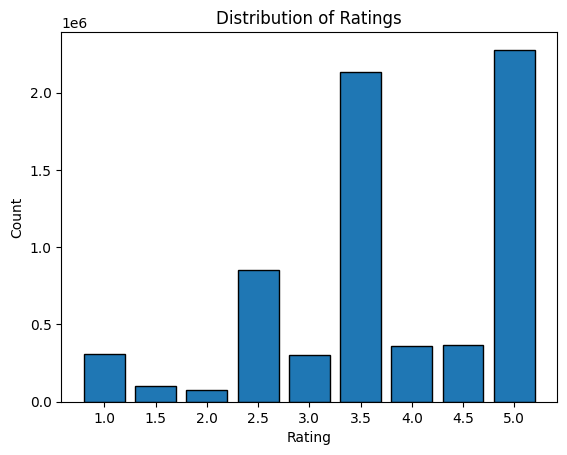

In [62]:
plt.bar(
    ratings_df['rating'],
    ratings_df['counts'],
    edgecolor='black',
    width=.4,
    tick_label = ratings_df['rating']
    )
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

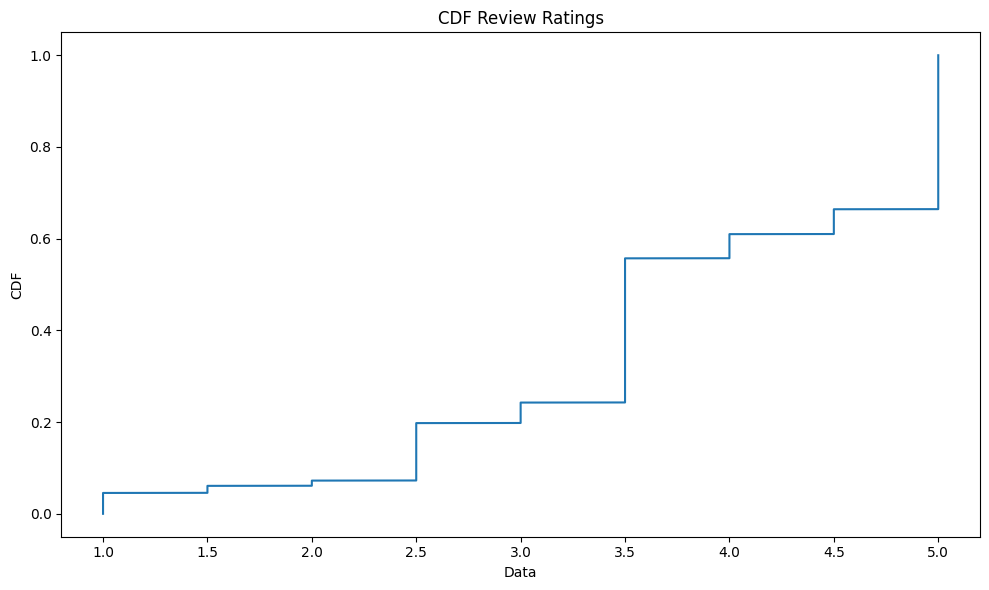

In [63]:
plot_cdf_with_focus(pd_reviews_df['rating'], None, None, 'CDF Review Ratings')

## Items' popularity EDA
POI SPIEGA BENE E FAI PURE LE CONSIDERAZIONI DATI I RISULTATI

DA RIVEDERE IL GRAFICO

In [64]:
videogames_popularity_df = reviews_df.groupby('steam_appid').count().orderBy('count')

In [65]:
videogames_popularity_df.select('count').summary().show()

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|            79966|
|   mean|84.77656754120501|
| stddev|484.5537212185353|
|    min|                1|
|    25%|                2|
|    50%|                8|
|    75%|               32|
|    max|            39433|
+-------+-----------------+



In [66]:
pd_videogames_popularity_df = videogames_popularity_df.toPandas()

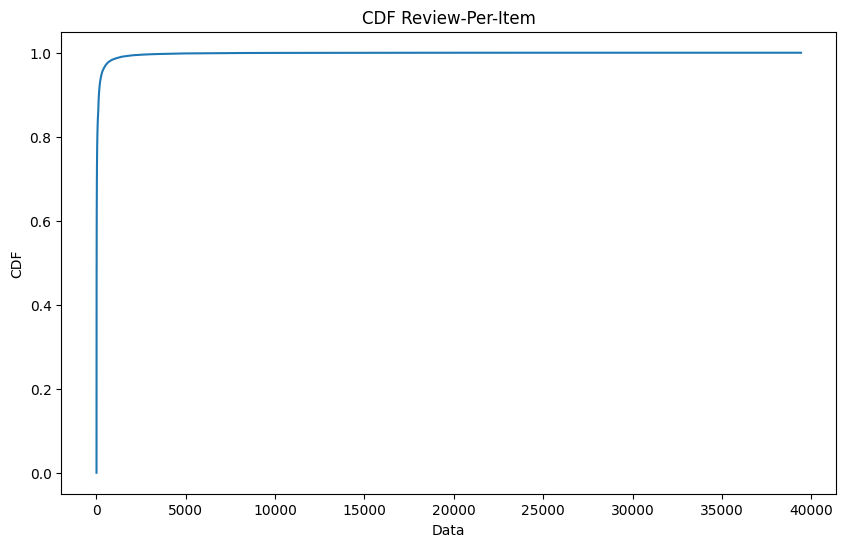

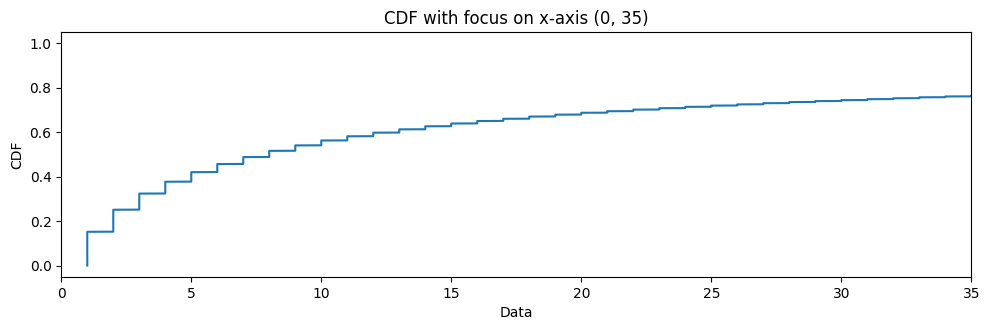

In [67]:
x_min = 0
x_max = 35
plot_cdf_with_focus(pd_videogames_popularity_df['count'], x_min, x_max, 'CDF Review-Per-Item', 'CDF with focus on x-axis ('+str(x_min)+', '+str(x_max)+')' )

## Users' Activity EDA
SPIEGA BENE PURE QUA

In [68]:
ratings_per_user = (
    reviews_df
    .groupBy('steam_id')
    .count()
    .orderBy('count', ascending=False)
)

In [69]:
ratings_per_user.select('count').summary().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|            291652|
|   mean|23.244287712753554|
| stddev| 60.50570284228065|
|    min|                 1|
|    25%|                 3|
|    50%|                 9|
|    75%|                24|
|    max|              9296|
+-------+------------------+



In [70]:
pd_ratings_per_user = ratings_per_user.toPandas()

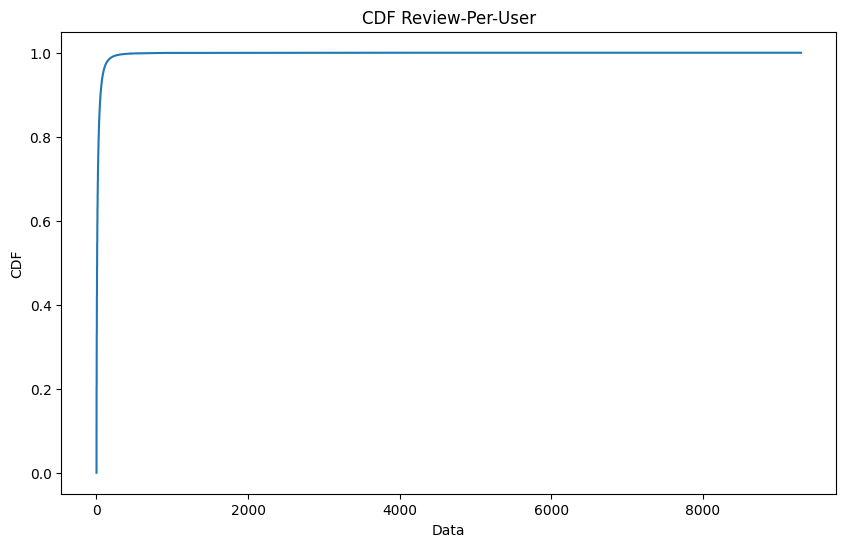

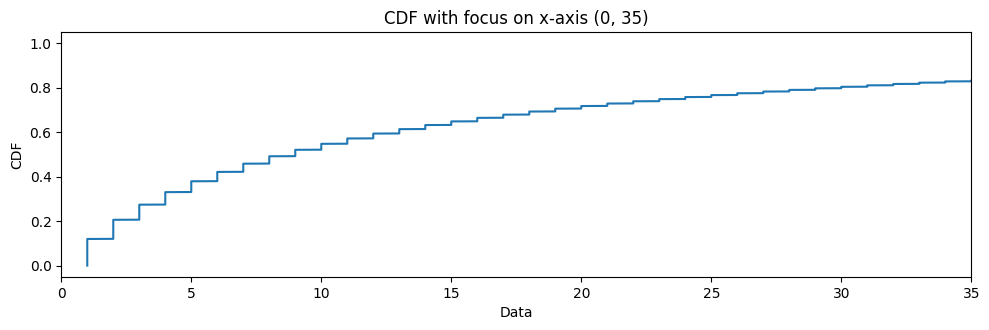

In [71]:
x_min = 0
x_max = 35
plot_cdf_with_focus(pd_ratings_per_user['count'], x_min, x_max, 'CDF Review-Per-User', 'CDF with focus on x-axis ('+str(x_min)+', '+str(x_max)+')' )